# Automated Log Classification with NLP

This notebook demonstrates how to build an automated log classification system using Natural Language Processing (NLP) techniques. We'll classify log messages into INFO, WARN, and ERROR categories to enable intelligent monitoring and alerting.

## Workflow Overview
1. Generate and explore synthetic log data
2. Preprocess log messages using NLP techniques
3. Extract features using TF-IDF vectorization
4. Train and evaluate classification models
5. Analyze model performance and insights
6. Demonstrate practical application

## 1. Environment Setup

First, let's import the necessary libraries and set up our environment.

In [76]:
# Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import random
from datetime import datetime, timedelta

# For NLP
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# For machine learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Ensure NLTK resources are available
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Set plot style
plt.style.use('ggplot')
sns.set(font_scale=1.2)

[nltk_data] Downloading package punkt to C:\Users\behip/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\behip/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\behip/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\behip/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## 2. Data Generation and Exploration

In a real-world scenario, we would collect log data from various systems. For this exercise, we'll generate synthetic log data that mimics typical patterns seen in production environments.

In [77]:
def generate_sample_logs(n_samples=1000):
    """
    Generate synthetic log data with timestamps, messages, and severity levels.
    
    Args:
        n_samples: Number of log entries to generate
        
    Returns:
        DataFrame with columns: timestamp, message, level
    """
    # Define templates for different log levels
    info_templates = [
        "User {} logged in successfully",
        "Connection established to {}",
        "Successfully processed {} items in batch job #{}",
        "API request completed in {}ms",
        "Service {} started successfully",
        "Database connection pool initialized with {} connections",
        "Cache refreshed for {} entries",
        "File {} uploaded successfully",
        "User session {} created",
        "Scheduled task {} completed"
    ]
    
    warn_templates = [
        "High memory usage detected: {}%",
        "Request to {} took {}ms, exceeding threshold",
        "Service {} response time degraded",
        "Retrying connection to {} (attempt {} of 3)",
        "Database query took {}ms, consider optimization",
        "API rate limit approaching: {} requests of {} limit",
        "Deprecated method {} called by service {}",
        "Slow disk I/O detected on volume {}",
        "Config {} using default values, no custom config found",
        "Cache hit ratio below threshold: {}%"
    ]
    
    error_templates = [
        "Failed to connect to database after {} retries",
        "Exception in thread '{}': {}",
        "Service {} crashed with exit code {}",
        "Unable to process request: {}",
        "Fatal error in module {}: {}",
        "Connection timeout after {}ms",
        "Authentication failed for user {}",
        "Out of memory error in service {}",
        "Data corruption detected in file {}",
        "Unhandled exception: {}"
    ]
    
    # Create lists to store data
    timestamps = []
    messages = []
    levels = []
    
    # Generate random distribution of log levels (more INFO than WARN or ERROR)
    level_choices = ['INFO', 'WARN', 'ERROR']
    level_weights = [0.7, 0.2, 0.1]  # 70% INFO, 20% WARN, 10% ERROR
    
    # Generate starting timestamp
    start_time = datetime(2025, 8, 1, 0, 0, 0)
    
    for i in range(n_samples):
        # Generate timestamp with some randomization
        timestamp = start_time + timedelta(
            minutes=random.randint(0, 5) + i * 5,
            seconds=random.randint(0, 59)
        )
        timestamps.append(timestamp)
        
        # Select log level
        level = random.choices(level_choices, weights=level_weights)[0]
        levels.append(level)
        
        # Generate message based on level
        if level == 'INFO':
            template = random.choice(info_templates)
            
            # Fill in the template with random values
            if "{}" in template:
                if "User" in template and "logged in" in template:
                    message = template.format(f"user_{random.randint(1000, 9999)}")
                elif "Connection established" in template:
                    services = ["database", "api", "auth-service", "cache", "queue"]
                    message = template.format(random.choice(services))
                elif "processed" in template:
                    message = template.format(
                        random.randint(10, 1000), 
                        random.randint(1000, 9999)
                    )
                elif "API request" in template:
                    message = template.format(random.randint(5, 100))
                elif "Service" in template:
                    services = ["web-server", "auth-service", "payment-processor", "data-indexer", "monitoring"]
                    message = template.format(random.choice(services))
                elif "Database connection" in template:
                    message = template.format(random.randint(5, 50))
                elif "Cache refreshed" in template:
                    message = template.format(random.randint(100, 10000))
                elif "File" in template:
                    message = template.format(f"data_{random.randint(1000, 9999)}.json")
                elif "User session" in template:
                    message = template.format(f"session_{random.randint(10000, 99999)}")
                elif "Scheduled task" in template:
                    tasks = ["backup", "cleanup", "index-rebuild", "report-generation", "health-check"]
                    message = template.format(random.choice(tasks))
                else:
                    message = template.format(random.randint(1, 100))
            else:
                message = template
                
        elif level == 'WARN':
            template = random.choice(warn_templates)
            
            # Fill in the template with random values
            if "{}" in template:
                if "memory usage" in template:
                    message = template.format(random.randint(80, 95))
                elif "Request to" in template:
                    services = ["auth-api", "payment-gateway", "data-service", "user-profile", "recommendation-engine"]
                    message = template.format(random.choice(services), random.randint(200, 500))
                elif "Service" in template and "response time" in template:
                    services = ["database", "auth-service", "storage-service", "search-index", "cache"]
                    message = template.format(random.choice(services))
                elif "Retrying connection" in template:
                    endpoints = ["db-primary", "redis-cache", "message-queue", "api-gateway", "storage-service"]
                    message = template.format(random.choice(endpoints), random.randint(1, 2))
                elif "Database query" in template:
                    message = template.format(random.randint(500, 2000))
                elif "API rate limit" in template:
                    message = template.format(random.randint(80, 95), 100)
                elif "Deprecated method" in template:
                    methods = ["getUserByID", "processLegacyFormat", "connectToOldAPI", "parseConfig", "renderView"]
                    services = ["user-service", "payment-processor", "admin-panel", "data-connector", "frontend"]
                    message = template.format(random.choice(methods), random.choice(services))
                elif "Slow disk I/O" in template:
                    volumes = ["data-vol", "log-vol", "backup-vol", "temp-vol", "app-vol"]
                    message = template.format(random.choice(volumes))
                elif "Config" in template:
                    configs = ["database", "cache", "logging", "security", "network"]
                    message = template.format(random.choice(configs))
                elif "Cache hit ratio" in template:
                    message = template.format(random.randint(30, 60))
                else:
                    message = template.format(random.randint(1, 100))
            else:
                message = template
                
        else:  # ERROR
            template = random.choice(error_templates)
            
            # Fill in the template with random values
            if "{}" in template:
                if "Failed to connect" in template:
                    message = template.format(random.randint(3, 5))
                elif "Exception in thread" in template:
                    threads = ["main", "worker", "processing", "io-handler", "listener"]
                    exceptions = [
                        "java.lang.NullPointerException", 
                        "java.sql.SQLException: Connection refused",
                        "OutOfMemoryError: Java heap space",
                        "java.net.ConnectException: Connection timed out",
                        "java.io.FileNotFoundException"
                    ]
                    message = template.format(random.choice(threads), random.choice(exceptions))
                elif "Service" in template and "crashed" in template:
                    services = ["api-server", "worker-process", "cron-job", "database-service", "auth-provider"]
                    message = template.format(random.choice(services), random.randint(1, 255))
                elif "Unable to process request" in template:
                    reasons = [
                        "Invalid input data", 
                        "Service unavailable", 
                        "Database timeout", 
                        "Required fields missing",
                        "Unauthorized access attempt"
                    ]
                    message = template.format(random.choice(reasons))
                elif "Fatal error in module" in template:
                    modules = ["PaymentProcessor", "UserAuthentication", "DataImporter", "ReportGenerator", "APIClient"]
                    errors = [
                        "Failed to initialize", 
                        "Configuration missing", 
                        "Dependency unavailable",
                        "Runtime exception",
                        "Invalid state detected"
                    ]
                    message = template.format(random.choice(modules), random.choice(errors))
                elif "Connection timeout" in template:
                    message = template.format(random.randint(3000, 30000))
                elif "Authentication failed" in template:
                    message = template.format(f"user_{random.randint(1000, 9999)}")
                elif "Out of memory error" in template:
                    services = ["search-indexer", "batch-processor", "report-generator", "data-aggregator", "image-processor"]
                    message = template.format(random.choice(services))
                elif "Data corruption" in template:
                    message = template.format(f"data_{random.randint(1000, 9999)}.db")
                elif "Unhandled exception" in template:
                    exceptions = [
                        "DivideByZeroException", 
                        "IndexOutOfRangeException", 
                        "KeyNotFoundException",
                        "ObjectDisposedException",
                        "InvalidOperationException"
                    ]
                    message = template.format(random.choice(exceptions))
                else:
                    message = template.format(random.randint(1, 100))
            else:
                message = template
        
        messages.append(message)
    
    # Create DataFrame
    logs_df = pd.DataFrame({
        'timestamp': timestamps,
        'message': messages,
        'level': levels
    })
    
    
    return logs_df

# Set random seed for reproducibility
random.seed(42)

# Generate logs
logs_df = generate_sample_logs(n_samples=1000)
# ...in your notebook...
logs_df.to_csv("synthetic_logs.log", index=False)

# Display sample of the data
print(f"Generated {len(logs_df)} log entries")
logs_df.head()

Generated 1000 log entries


,timestamp,message,level
0,2025-08-01 00:05:07,Service auth-service started successfully,INFO
1,2025-08-01 00:06:08,"Config database using default values, no custo...",WARN
2,2025-08-01 00:14:27,Connection established to api,INFO
3,2025-08-01 00:16:32,User session session_36062 created,INFO
4,2025-08-01 00:25:41,Deprecated method processLegacyFormat called b...,WARN


### 2.1 Exploratory Data Analysis

Let's explore the dataset to understand its characteristics:
1. Distribution of log levels
2. Message length by log level
3. Common words in each level

Distribution of log levels:
level
INFO     687
WARN     218
ERROR     95
Name: count, dtype: int64
INFO: 68.70%
WARN: 21.80%
ERROR: 9.50%


C:\Users\behip\AppData\Local\Temp\ipykernel_18572\1547227426.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='level', data=logs_df, palette=['#66b3ff', '#ffcc99', '#ff9999'])


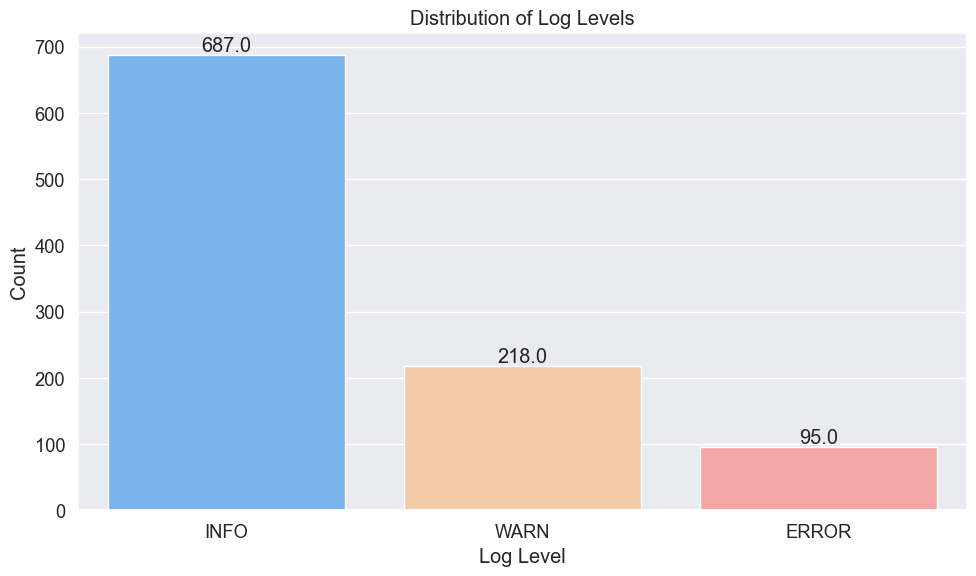

In [78]:
# Distribution of log levels
level_counts = logs_df['level'].value_counts()
print("Distribution of log levels:")
print(level_counts)

# Calculate percentages
level_percentages = level_counts / len(logs_df) * 100
for level, percentage in level_percentages.items():
    print(f"{level}: {percentage:.2f}%")

# Plot distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='level', data=logs_df, palette=['#66b3ff', '#ffcc99', '#ff9999'])
plt.title('Distribution of Log Levels')
plt.xlabel('Log Level')
plt.ylabel('Count')

# Add count labels on bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom')

plt.tight_layout()
plt.show()

C:\Users\behip\AppData\Local\Temp\ipykernel_18572\2179789081.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='level', y='message_length', data=logs_df, palette='Set3')


Message length statistics by level:
       count       mean        std   min   25%   50%    75%   max
level                                                            
ERROR   95.0  46.768421  10.731196  31.0  40.0  45.0  50.00  77.0
INFO   687.0  38.905386   8.382166  28.0  32.0  37.0  41.00  56.0
WARN   218.0  48.229358  10.206741  31.0  40.0  49.5  55.75  73.0


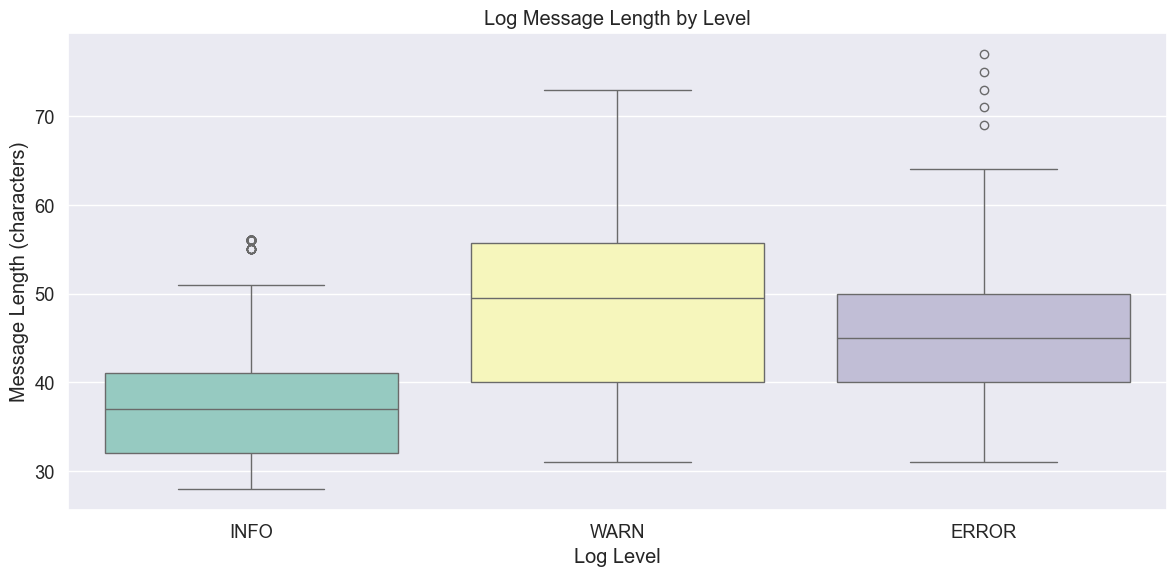

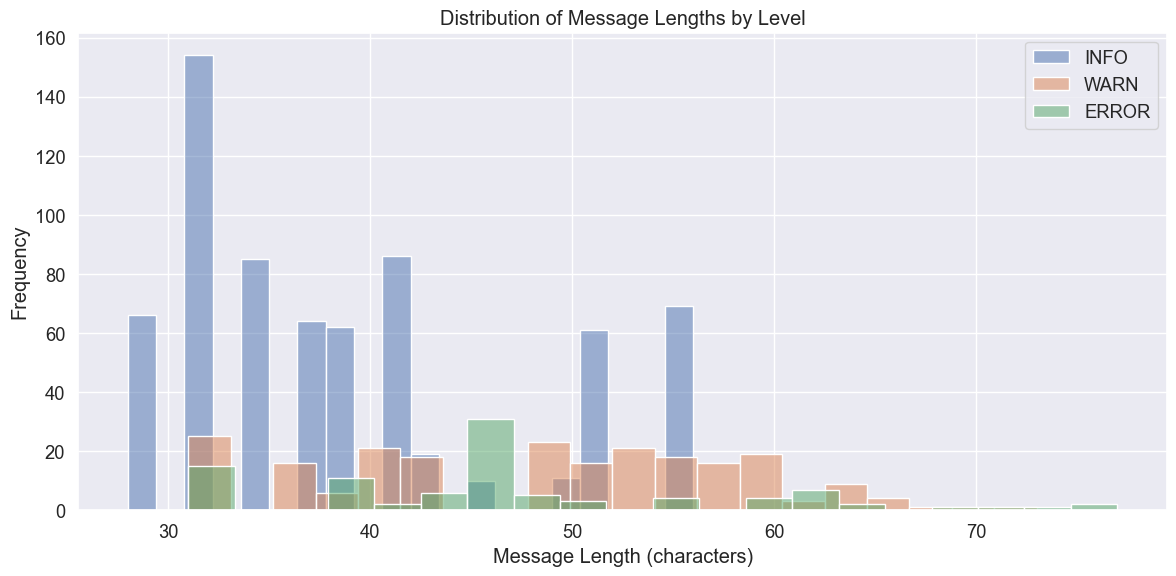

In [79]:
# Analyze log message length by level
logs_df['message_length'] = logs_df['message'].apply(len)

# Summary statistics by level
length_stats = logs_df.groupby('level')['message_length'].describe()
print("Message length statistics by level:")
print(length_stats)

# Boxplot of message length by level
plt.figure(figsize=(12, 6))
sns.boxplot(x='level', y='message_length', data=logs_df, palette='Set3')
plt.title('Log Message Length by Level')
plt.xlabel('Log Level')
plt.ylabel('Message Length (characters)')
plt.tight_layout()
plt.show()

# Histogram of message lengths
plt.figure(figsize=(12, 6))
for level in logs_df['level'].unique():
    subset = logs_df[logs_df['level'] == level]
    sns.histplot(subset['message_length'], label=level, alpha=0.5, bins=20)

plt.title('Distribution of Message Lengths by Level')
plt.xlabel('Message Length (characters)')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

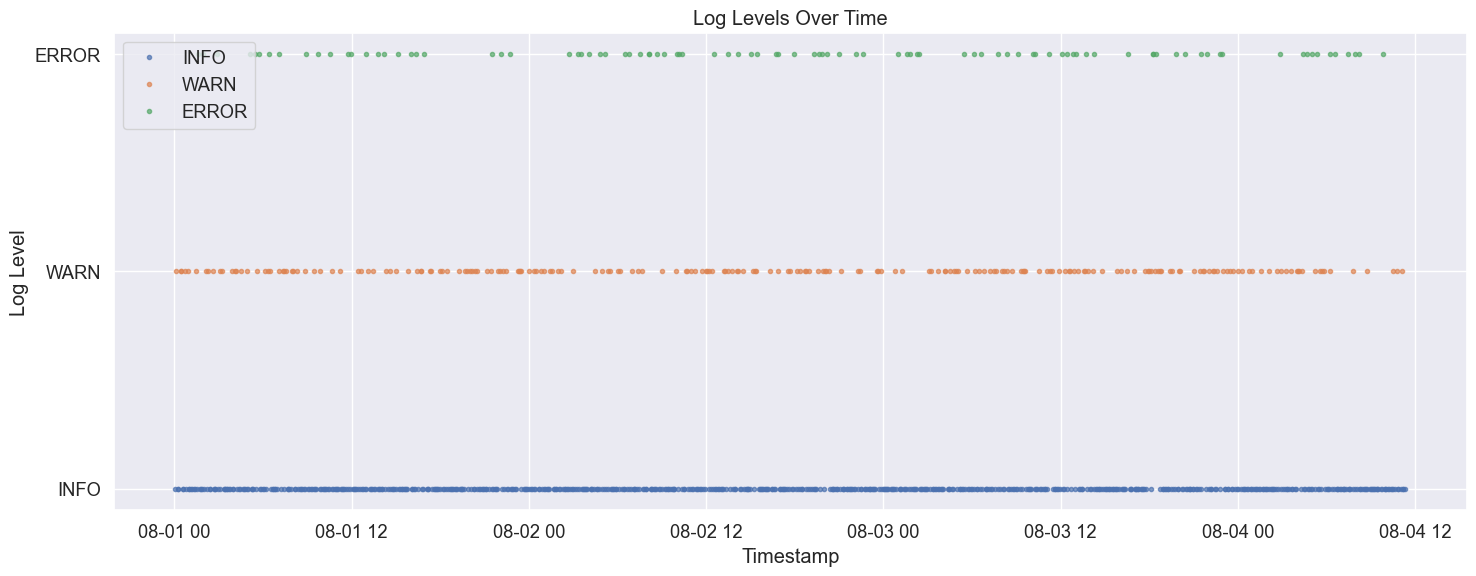


Most common words in INFO logs:
  successfully: 249
  connection: 147
  completed: 134
  user: 119
  cache: 105
  refreshed: 86
  entries: 86
  database: 83
  scheduled: 79
  task: 79

Most common words in WARN logs:
  detected: 51
  took: 50
  config: 44
  threshold: 43
  service: 40
  database: 32
  limit: 30
  request: 27
  exceeding: 27
  slow: 26

Most common words in ERROR logs:
  failed: 23
  connection: 20
  timeout: 20
  error: 20
  exception: 18
  service: 17
  database: 14
  fatal: 11
  module: 11
  thread: 11


In [80]:
# Distribution of log levels over time
plt.figure(figsize=(15, 6))
for level in logs_df['level'].unique():
    level_data = logs_df[logs_df['level'] == level]
    plt.plot(level_data['timestamp'], [level] * len(level_data), '.', label=level, alpha=0.7)

plt.title('Log Levels Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Log Level')
plt.legend()
plt.tight_layout()
plt.show()

# Analyze common words in each level
from collections import Counter
import string

def extract_common_words(messages, top_n=10):
    """Extract most common words from a list of messages"""
    # Combine all messages
    all_text = ' '.join(messages).lower()
    
    # Remove punctuation
    all_text = all_text.translate(str.maketrans('', '', string.punctuation))
    
    # Split into words
    words = all_text.split()
    
    # Remove common English stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Count words
    word_counts = Counter(words)
    
    # Return top N words
    return word_counts.most_common(top_n)

# Get common words for each level
for level in logs_df['level'].unique():
    level_messages = logs_df[logs_df['level'] == level]['message']
    common_words = extract_common_words(level_messages)
    
    print(f"\nMost common words in {level} logs:")
    for word, count in common_words:
        print(f"  {word}: {count}")

## 3. Text Preprocessing with NLP

Now that we understand our data, let's preprocess the log messages to prepare them for machine learning:

1. Convert text to lowercase
2. Remove special characters and numbers
3. Tokenize the text into individual words
4. Remove common stopwords (like "the", "a", "in")
5. Apply lemmatization (reducing words to their base form)

In [81]:
# Improved NLTK resource setup and robust preprocessing
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required NLTK resources (ignore errors if already present)
for resource in ['punkt', 'punkt_tab', 'stopwords', 'wordnet', 'omw-1.4']:
    try:
        nltk.download(resource, quiet=True)
    except Exception as e:
        print(f"Error downloading {resource}: {e}")

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    # Try NLTK tokenization, fallback to split if error
    try:
        tokens = word_tokenize(text)
    except Exception as e:
        print(f"NLTK tokenization error: {e}")
        tokens = text.split()
    # Remove stopwords but keep negations
    try:
        stop_words = set(stopwords.words('english'))
        negation_words = {"no", "not", "none", "never", "without", "cannot", "n't"}
        stop_words = stop_words - negation_words
    except Exception as e:
        print(f"NLTK stopwords error: {e}")
        stop_words = set()
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    # Lemmatize
    try:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    except Exception as e:
        print(f"NLTK lemmatizer error: {e}")
    # Join back to string
    return ' '.join(tokens)

logs_df['processed_message'] = logs_df['message'].apply(preprocess_text)

# Display original and processed messages for first 5 logs
print("Sample preprocessing output:")
for i in range(5):
    print(f"Original:   {logs_df['message'].iloc[i]}")
    print(f"Processed:  {logs_df['processed_message'].iloc[i]}")
    print("---")

Sample preprocessing output:
Original:   Service auth-service started successfully
Processed:  service auth service started successfully
---
Original:   Config database using default values, no custom config found
Processed:  config database using default value no custom config found
---
Original:   Connection established to api
Processed:  connection established api
---
Original:   User session session_36062 created
Processed:  user session session created
---
Original:   Deprecated method processLegacyFormat called by service data-connector
Processed:  deprecated method processlegacyformat called service data connector
---


### 3.1 Analyzing the Impact of Preprocessing

Let's examine how preprocessing has changed our log messages and what impact it has on our data.


Summary statistics:
count: 1000 messages checked.
mean: On average, each message was shortened by 15.77%.
std: The shortening varies by about 10.57% between messages.
min: The smallest reduction was 0.00% (some messages weren't shortened).
25%: A quarter of messages were shortened by less than 8.82%.
50%: Half of messages were shortened by less than 16.07%.
75%: Three-quarters of messages were shortened by less than 21.76%.
max: The biggest reduction was 37.50% (most shortened message).


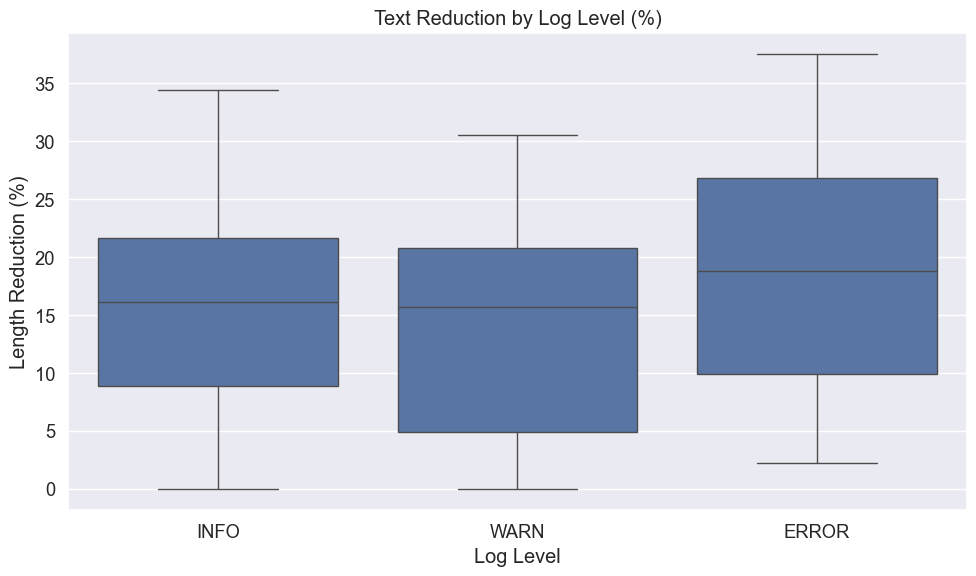

Original vocabulary size: 762 unique terms
Processed vocabulary size: 162 unique terms
Vocabulary reduction: 600 terms (78.74%)


In [82]:
# Analyze preprocessing impact on message length
logs_df['original_length'] = logs_df['message'].apply(len)
logs_df['processed_length'] = logs_df['processed_message'].apply(len)
logs_df['length_reduction'] = logs_df['original_length'] - logs_df['processed_length']
logs_df['length_reduction_pct'] = (logs_df['length_reduction'] / logs_df['original_length']) * 100

# Summary statistics
print("\nSummary statistics:")
print(f"count: {int(stats['count'])} messages checked.")
print(f"mean: On average, each message was shortened by {stats['mean']:.2f}%.")
print(f"std: The shortening varies by about {stats['std']:.2f}% between messages.")
print(f"min: The smallest reduction was {stats['min']:.2f}% (some messages weren't shortened).")
print(f"25%: A quarter of messages were shortened by less than {stats['25%']:.2f}%.")
print(f"50%: Half of messages were shortened by less than {stats['50%']:.2f}%.")
print(f"75%: Three-quarters of messages were shortened by less than {stats['75%']:.2f}%.")
print(f"max: The biggest reduction was {stats['max']:.2f}% (most shortened message).")

# Plot length reduction by level
plt.figure(figsize=(10, 6))
sns.boxplot(x='level', y='length_reduction_pct', data=logs_df)
plt.title('Text Reduction by Log Level (%)')
plt.xlabel('Log Level')
plt.ylabel('Length Reduction (%)')
plt.tight_layout()
plt.show()

# Vocabulary size analysis
original_vocab = set()
processed_vocab = set()

for msg in logs_df['message']:
    words = re.findall(r'\b\w+\b', msg.lower())
    original_vocab.update(words)

for msg in logs_df['processed_message']:
    words = msg.split()
    processed_vocab.update(words)

print(f"Original vocabulary size: {len(original_vocab)} unique terms")
print(f"Processed vocabulary size: {len(processed_vocab)} unique terms")
print(f"Vocabulary reduction: {len(original_vocab) - len(processed_vocab)} terms ({((len(original_vocab) - len(processed_vocab)) / len(original_vocab)) * 100:.2f}%)")

## 4. Feature Extraction with TF-IDF

Now, we'll convert our preprocessed text data into numerical features using Term Frequency-Inverse Document Frequency (TF-IDF) vectorization. This technique:

1. Emphasizes words that are common within a document but rare across documents
2. De-emphasizes words that appear frequently across all documents
3. Creates a sparse matrix representing our log messages as numerical features

In [83]:
# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(
    max_features=1000,  # Limit to top 1000 features
    ngram_range=(1, 2), # Include both unigrams and bigrams
    min_df=2,           # Ignore terms that appear in fewer than 2 documents
    max_df=0.9          # Ignore terms that appear in more than 90% of documents
)

# Fit and transform the preprocessed messages
X = vectorizer.fit_transform(logs_df['processed_message'])
y = logs_df['level']

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Display vectorization results
print(f"Shape of feature matrix: {X.shape}")
print(f"Number of features: {len(feature_names)}")
print(f"Sample features: {feature_names[:20]}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Shape of feature matrix: (1000, 355)
Number of features: 355
Sample features: ['admin' 'admin panel' 'aggregator' 'api' 'api gateway' 'api rate'
 'api request' 'api took' 'apiclient' 'app' 'app vol' 'approaching'
 'approaching request' 'attempt' 'auth' 'auth api' 'auth provider'
 'auth service' 'authentication' 'authentication failed']
Training set shape: (700, 355)
Testing set shape: (300, 355)

Number of features: 355
Sample features: ['admin' 'admin panel' 'aggregator' 'api' 'api gateway' 'api rate'
 'api request' 'api took' 'apiclient' 'app' 'app vol' 'approaching'
 'approaching request' 'attempt' 'auth' 'auth api' 'auth provider'
 'auth service' 'authentication' 'authentication failed']
Training set shape: (700, 355)
Testing set shape: (300, 355)


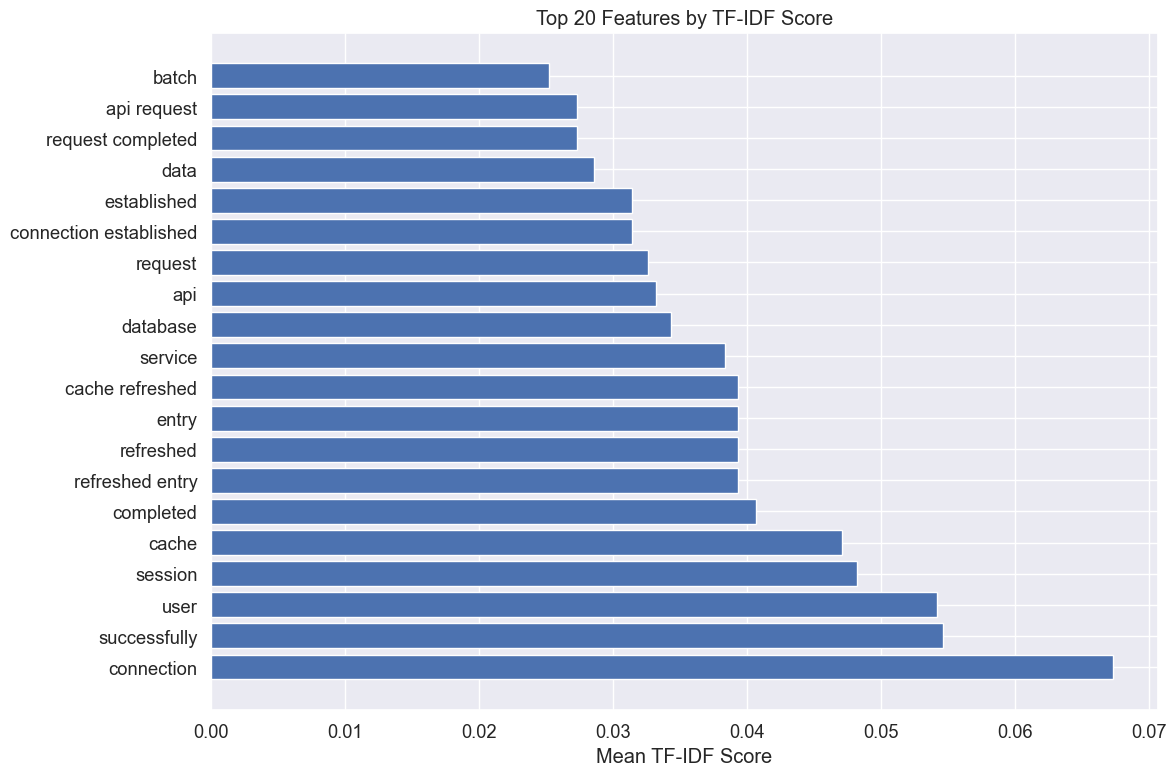

In [84]:
# Visualize the most important features by TF-IDF score
def plot_top_features(vectorizer, top_n=20):
    """Plot the top features by their average TF-IDF score"""
    # Convert sparse matrix to dense
    X_dense = X.toarray()
    
    # Calculate mean TF-IDF score for each feature
    feature_means = X_dense.mean(axis=0)
    
    # Get indices of top features
    top_indices = feature_means.argsort()[-top_n:][::-1]
    
    # Get names and scores of top features
    top_features = [feature_names[i] for i in top_indices]
    top_scores = feature_means[top_indices]
    
    # Create a bar plot
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_features)), top_scores, align='center')
    plt.yticks(range(len(top_features)), top_features)
    plt.xlabel('Mean TF-IDF Score')
    plt.title(f'Top {top_n} Features by TF-IDF Score')
    plt.tight_layout()
    plt.show()

# Plot top features
plot_top_features(vectorizer)

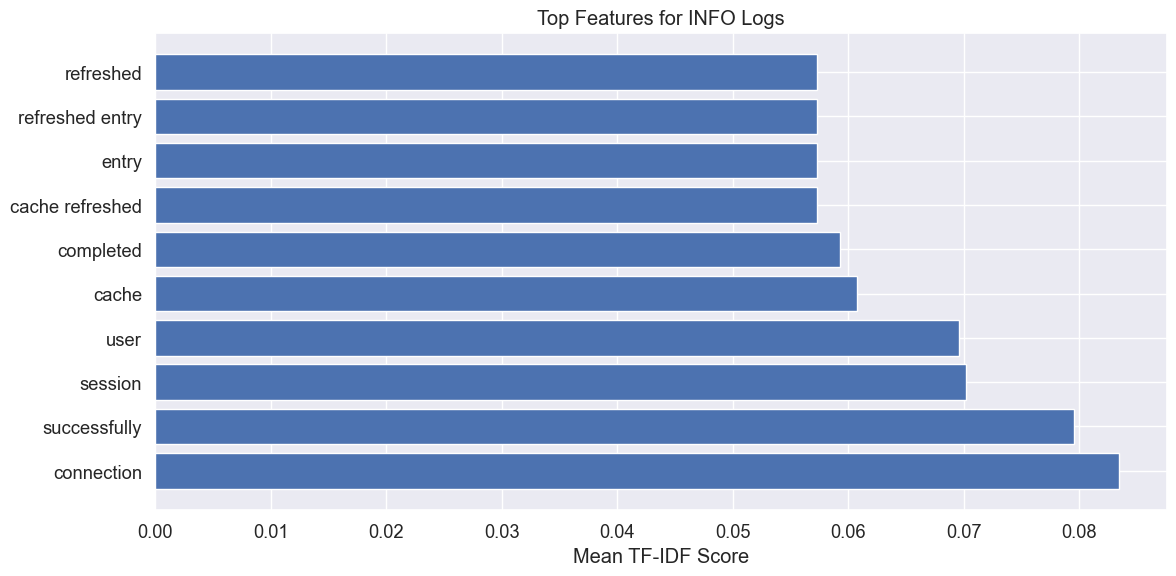


Top features for INFO logs:
  connection: 0.0834
  successfully: 0.0795
  session: 0.0702
  user: 0.0696
  cache: 0.0607
  completed: 0.0592
  cache refreshed: 0.0573
  entry: 0.0573
  refreshed entry: 0.0573
  refreshed: 0.0573


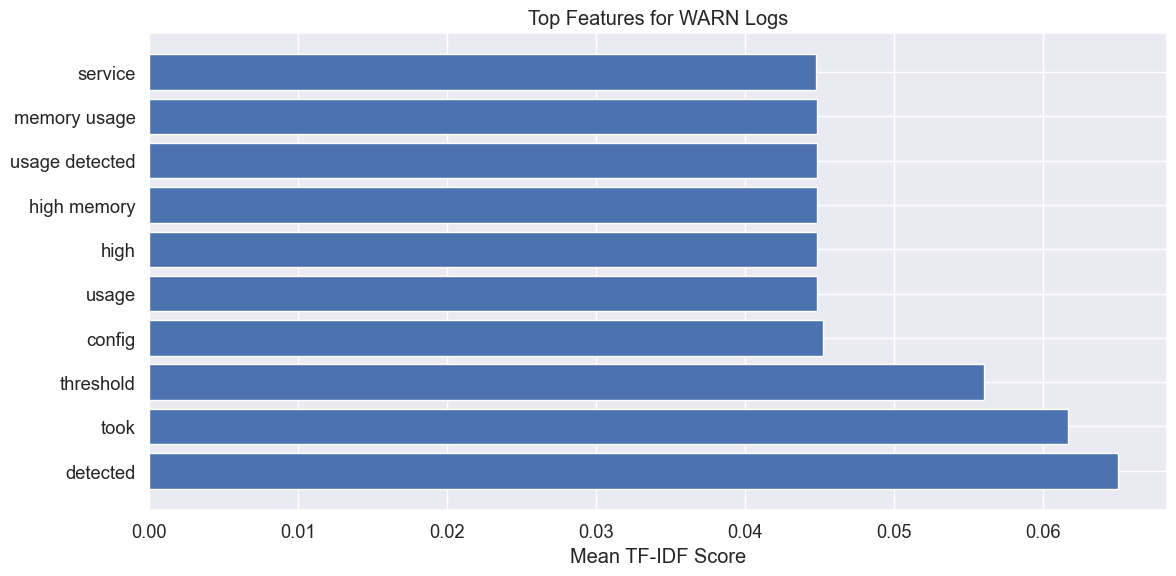


Top features for WARN logs:
  detected: 0.0651
  took: 0.0617
  threshold: 0.0560
  config: 0.0452
  usage: 0.0448
  high: 0.0448
  high memory: 0.0448
  usage detected: 0.0448
  memory usage: 0.0448
  service: 0.0448


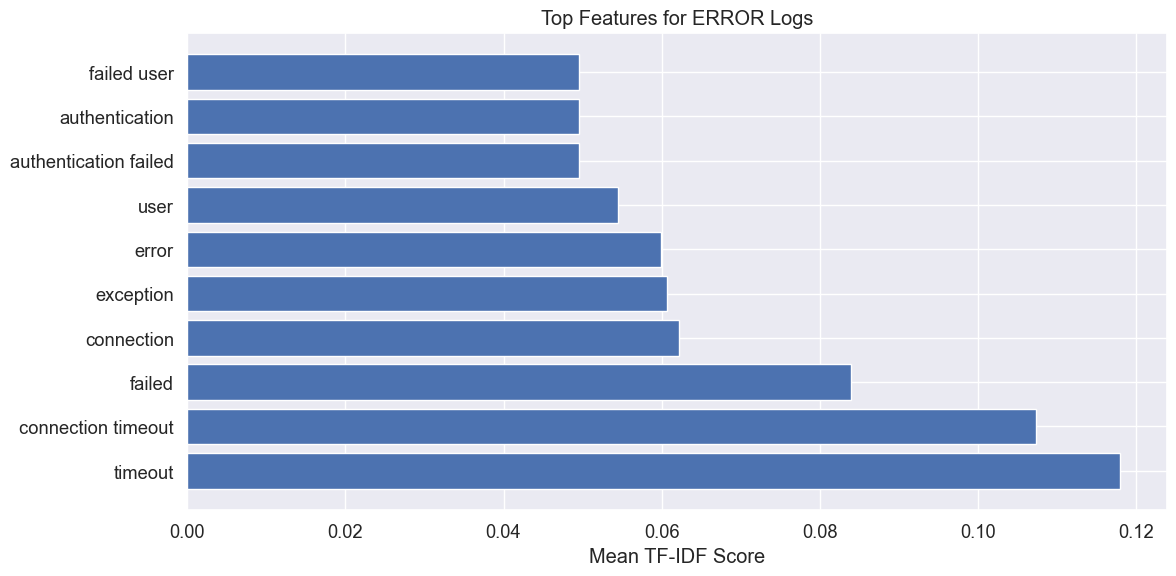


Top features for ERROR logs:
  timeout: 0.1179
  connection timeout: 0.1074
  failed: 0.0840
  connection: 0.0622
  exception: 0.0607
  error: 0.0599
  user: 0.0545
  authentication failed: 0.0495
  authentication: 0.0495
  failed user: 0.0495


In [85]:
# Analyze top features for each log level
def analyze_level_specific_features(logs_df, vectorizer, top_n=10):
    """Find most discriminative features for each log level"""
    feature_names = vectorizer.get_feature_names_out()
    
    # For each level, get the top features
    for level in logs_df['level'].unique():
        # Get messages for this level
        level_messages = logs_df[logs_df['level'] == level]['processed_message']
        
        # Vectorize only these messages
        level_X = vectorizer.transform(level_messages)
        
        # Calculate mean TF-IDF score for each feature
        level_means = level_X.toarray().mean(axis=0)
        
        # Get top indices
        top_indices = level_means.argsort()[-top_n:][::-1]
        
        # Get top features and scores
        top_features = [feature_names[i] for i in top_indices]
        top_scores = level_means[top_indices]
        
        # Create a bar plot
        plt.figure(figsize=(12, 6))
        plt.barh(range(len(top_features)), top_scores, align='center')
        plt.yticks(range(len(top_features)), top_features)
        plt.xlabel('Mean TF-IDF Score')
        plt.title(f'Top Features for {level} Logs')
        plt.tight_layout()
        plt.show()
        
        print(f"\nTop features for {level} logs:")
        for feature, score in zip(top_features, top_scores):
            print(f"  {feature}: {score:.4f}")

# Analyze level-specific features
analyze_level_specific_features(logs_df, vectorizer)

## 5. Model Training and Evaluation

Now we'll train two different classification models and evaluate their performance:
1. Logistic Regression - A simple linear model
2. Random Forest - An ensemble of decision trees

We'll compare these models to determine which one works best for our log classification task.


===== Logistic Regression Evaluation =====
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

       ERROR       1.00      1.00      1.00        29
        INFO       1.00      1.00      1.00       206
        WARN       1.00      1.00      1.00        65

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



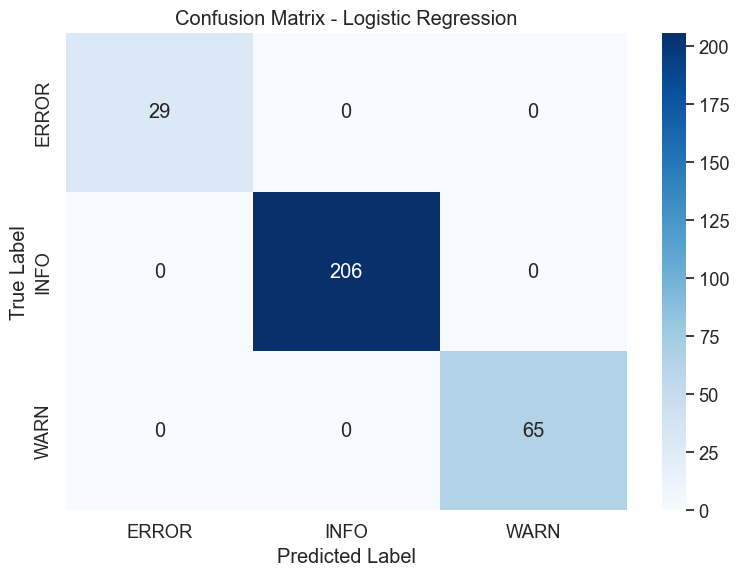


===== Random Forest Evaluation =====
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

       ERROR       1.00      1.00      1.00        29
        INFO       1.00      1.00      1.00       206
        WARN       1.00      1.00      1.00        65

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



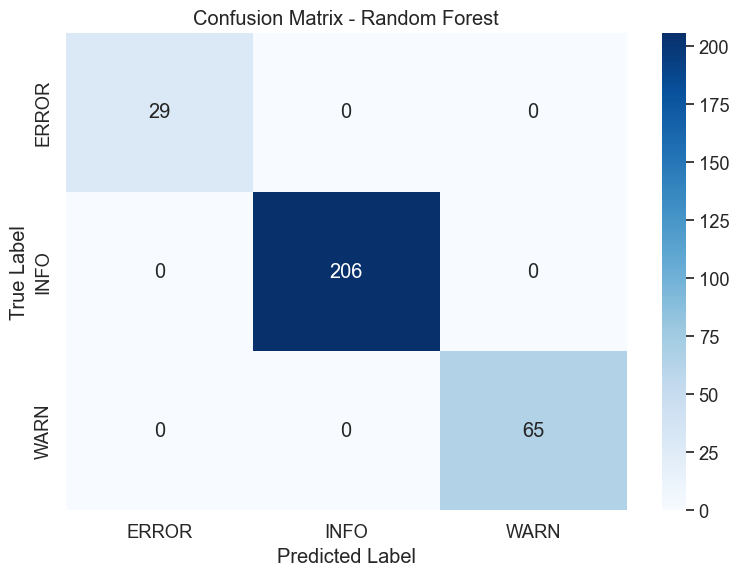

In [86]:
# Train a Logistic Regression model
lr_model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)
lr_model.fit(X_train, y_train)

# Train a Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train, y_train)

# Function to evaluate models
def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate a model and print metrics"""
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"\n===== {model_name} Evaluation =====")
    print(f"Accuracy: {accuracy:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return y_pred

# Evaluate both models
lr_pred = evaluate_model(lr_model, X_test, y_test, "Logistic Regression")
rf_pred = evaluate_model(rf_model, X_test, y_test, "Random Forest")

Logistic Regression misclassified 0/300 examples (0.00%)
Random Forest misclassified 0/300 examples (0.00%)

Misclassification by class:

ERROR:
  Logistic Regression: 0/29 (0.00%)
  Random Forest: 0/29 (0.00%)

INFO:
  Logistic Regression: 0/206 (0.00%)
  Random Forest: 0/206 (0.00%)

WARN:
  Logistic Regression: 0/65 (0.00%)
  Random Forest: 0/65 (0.00%)


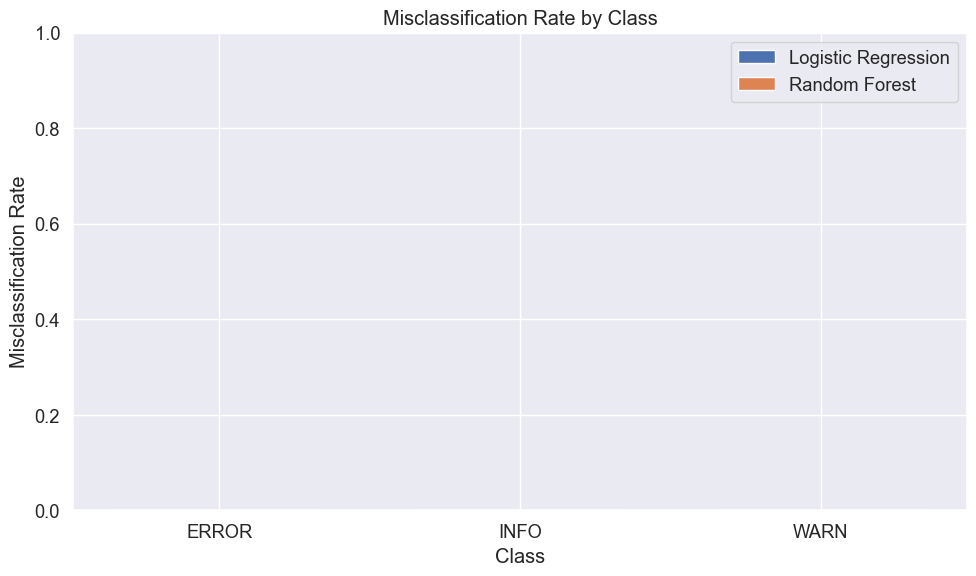

In [87]:
# Compare models by misclassification rates
misclassified_lr = y_test != lr_pred
misclassified_rf = y_test != rf_pred

print(f"Logistic Regression misclassified {misclassified_lr.sum()}/{len(y_test)} examples ({misclassified_lr.mean():.2%})")
print(f"Random Forest misclassified {misclassified_rf.sum()}/{len(y_test)} examples ({misclassified_rf.mean():.2%})")

# Compare misclassification by class
classes = np.unique(y_test)
print("\nMisclassification by class:")

for cls in classes:
    class_indices = y_test == cls
    n_class = class_indices.sum()
    
    n_misclassified_lr = (misclassified_lr & class_indices).sum()
    n_misclassified_rf = (misclassified_rf & class_indices).sum()
    
    print(f"\n{cls}:")
    print(f"  Logistic Regression: {n_misclassified_lr}/{n_class} ({n_misclassified_lr/n_class:.2%})")
    print(f"  Random Forest: {n_misclassified_rf}/{n_class} ({n_misclassified_rf/n_class:.2%})")

# Plot comparison
plt.figure(figsize=(10, 6))
x = np.arange(len(classes))
width = 0.35

lr_misclass_rates = []
rf_misclass_rates = []

for cls in classes:
    class_indices = y_test == cls
    n_class = class_indices.sum()
    
    lr_rate = (misclassified_lr & class_indices).sum() / n_class
    rf_rate = (misclassified_rf & class_indices).sum() / n_class
    
    lr_misclass_rates.append(lr_rate)
    rf_misclass_rates.append(rf_rate)

plt.bar(x - width/2, lr_misclass_rates, width, label='Logistic Regression')
plt.bar(x + width/2, rf_misclass_rates, width, label='Random Forest')

plt.xlabel('Class')
plt.ylabel('Misclassification Rate')
plt.title('Misclassification Rate by Class')
plt.xticks(x, classes)
plt.legend()
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

## 6. Feature Importance Analysis

Let's analyze which features (words and phrases) are most important for classifying log messages. This will give us insights into what distinguishes different log levels.

Logistic Regression Feature Importance:


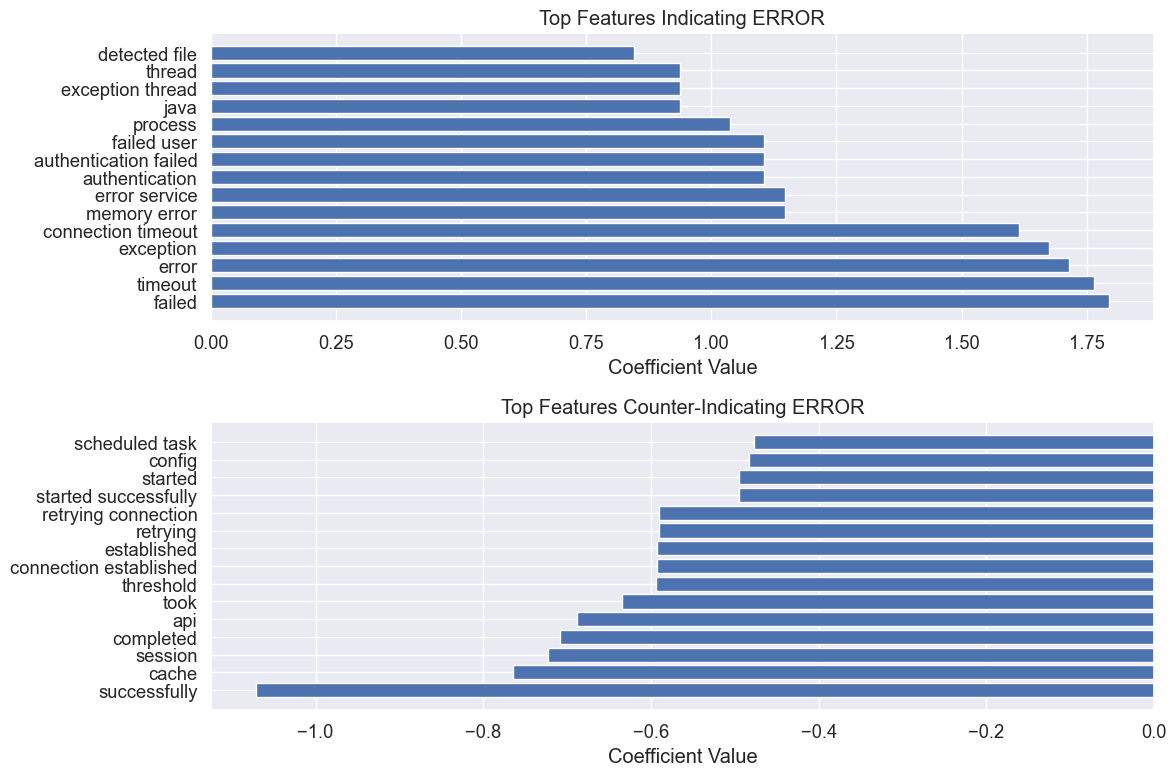


Top features indicating ERROR:
  failed: 1.7948
  timeout: 1.7649
  error: 1.7147
  exception: 1.6739
  connection timeout: 1.6153
  memory error: 1.1469
  error service: 1.1469
  authentication: 1.1061
  authentication failed: 1.1061
  failed user: 1.1061
  process: 1.0368
  java: 0.9375
  exception thread: 0.9375
  thread: 0.9375
  detected file: 0.8448

Top features counter-indicating ERROR:
  successfully: -1.0716
  cache: -0.7648
  session: -0.7224
  completed: -0.7080
  api: -0.6881
  took: -0.6342
  threshold: -0.5938
  connection established: -0.5930
  established: -0.5930
  retrying: -0.5904
  retrying connection: -0.5904
  started successfully: -0.4950
  started: -0.4950
  config: -0.4826
  scheduled task: -0.4767


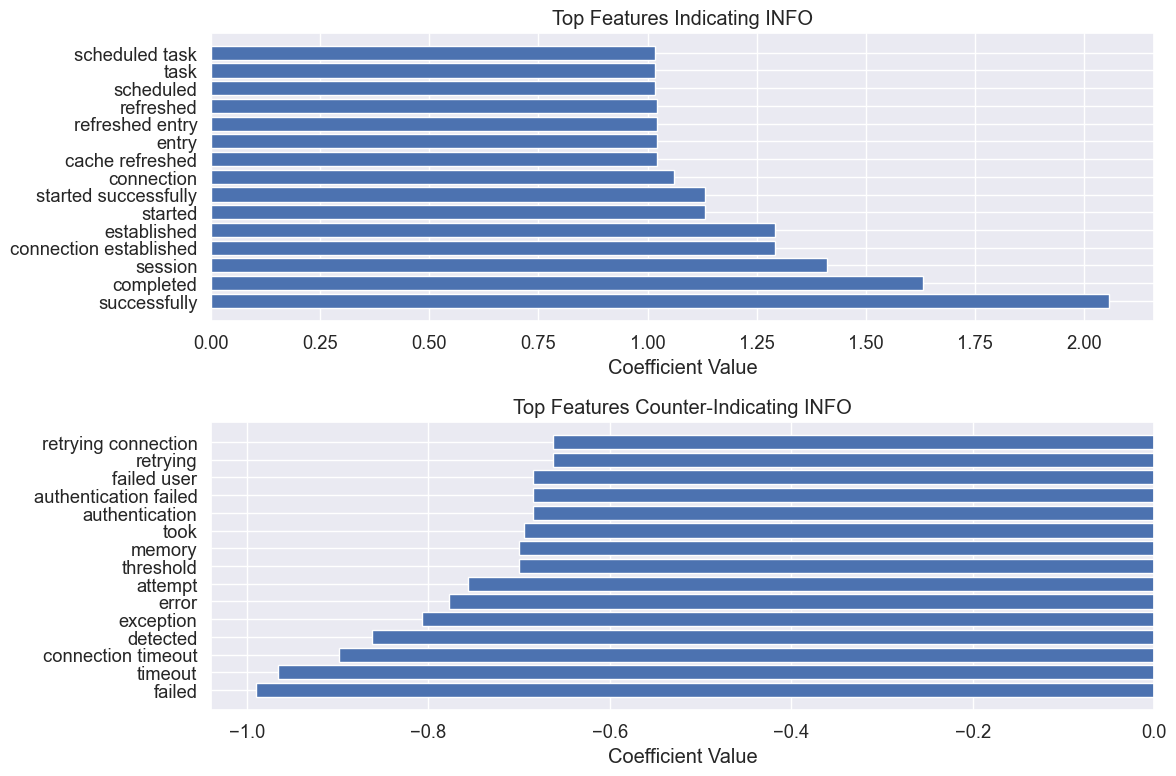


Top features indicating INFO:
  successfully: 2.0566
  completed: 1.6315
  session: 1.4102
  connection established: 1.2913
  established: 1.2913
  started: 1.1311
  started successfully: 1.1311
  connection: 1.0616
  cache refreshed: 1.0206
  entry: 1.0206
  refreshed entry: 1.0206
  refreshed: 1.0206
  scheduled: 1.0162
  task: 1.0162
  scheduled task: 1.0162

Top features counter-indicating INFO:
  failed: -0.9906
  timeout: -0.9662
  connection timeout: -0.8987
  detected: -0.8626
  exception: -0.8068
  error: -0.7774
  attempt: -0.7567
  threshold: -0.7000
  memory: -0.6999
  took: -0.6944
  authentication: -0.6848
  authentication failed: -0.6848
  failed user: -0.6848
  retrying: -0.6631
  retrying connection: -0.6631


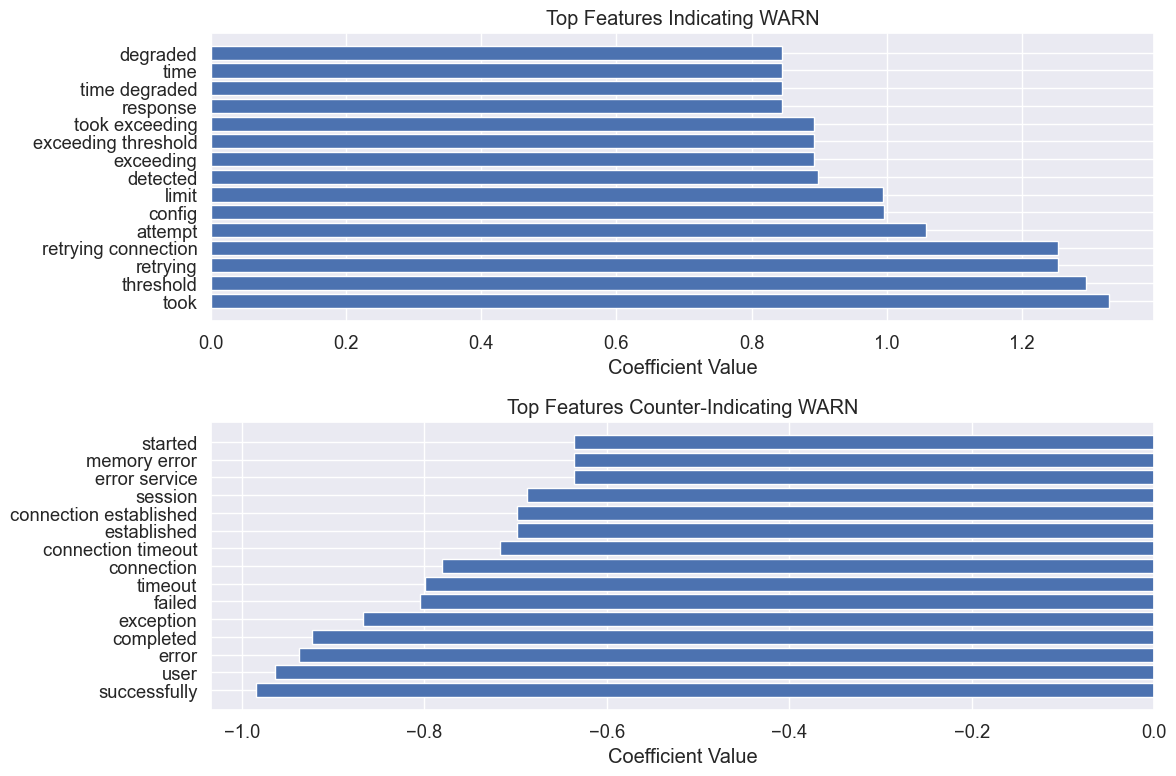


Top features indicating WARN:
  took: 1.3286
  threshold: 1.2939
  retrying: 1.2535
  retrying connection: 1.2535
  attempt: 1.0577
  config: 0.9960
  limit: 0.9939
  detected: 0.8982
  exceeding: 0.8919
  exceeding threshold: 0.8919
  took exceeding: 0.8919
  response: 0.8445
  time degraded: 0.8445
  time: 0.8445
  degraded: 0.8445

Top features counter-indicating WARN:
  successfully: -0.9850
  user: -0.9634
  error: -0.9372
  completed: -0.9235
  exception: -0.8672
  failed: -0.8042
  timeout: -0.7987
  connection: -0.7808
  connection timeout: -0.7166
  established: -0.6983
  connection established: -0.6983
  session: -0.6878
  error service: -0.6363
  memory error: -0.6363
  started: -0.6362

Random Forest Feature Importance:


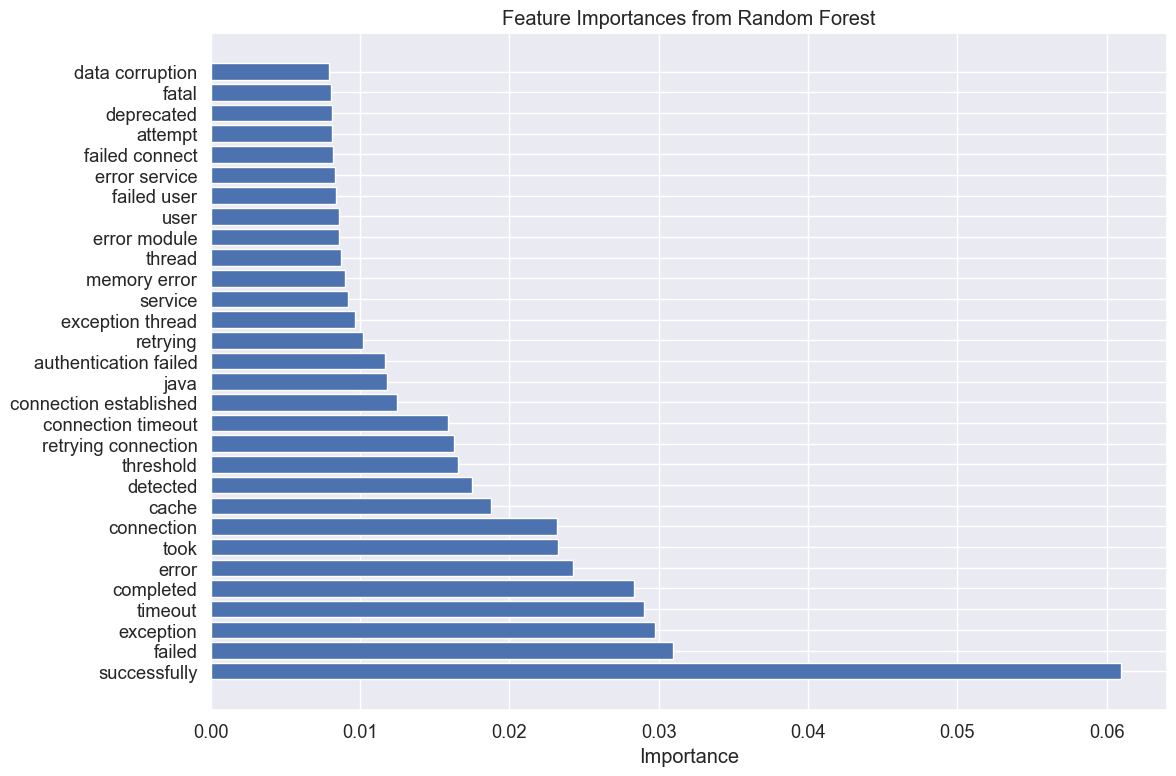


Top features by Random Forest importance:
  successfully: 0.0610
  failed: 0.0309
  exception: 0.0297
  timeout: 0.0290
  completed: 0.0283
  error: 0.0243
  took: 0.0233
  connection: 0.0232
  cache: 0.0188
  detected: 0.0175
  threshold: 0.0165
  retrying connection: 0.0163
  connection timeout: 0.0159
  connection established: 0.0125
  java: 0.0118
  authentication failed: 0.0117
  retrying: 0.0102
  exception thread: 0.0097
  service: 0.0092
  memory error: 0.0090
  thread: 0.0087
  error module: 0.0086
  user: 0.0086
  failed user: 0.0084
  error service: 0.0084
  failed connect: 0.0082
  attempt: 0.0081
  deprecated: 0.0081
  fatal: 0.0081
  data corruption: 0.0079


In [88]:
# For Logistic Regression, examine coefficients
def plot_lr_coefficients(model, feature_names, top_n=15):
    """Plot the most important features for each class based on logistic regression coefficients"""
    for i, class_label in enumerate(model.classes_):
        # Get coefficients for this class
        coefficients = model.coef_[i]
        
        # Get top positive coefficients (most indicative of this class)
        top_positive_idx = np.argsort(coefficients)[-top_n:]
        top_positive_features = [feature_names[j] for j in top_positive_idx]
        top_positive_coef = coefficients[top_positive_idx]
        
        # Get top negative coefficients (most counter-indicative of this class)
        top_negative_idx = np.argsort(coefficients)[:top_n]
        top_negative_features = [feature_names[j] for j in top_negative_idx]
        top_negative_coef = coefficients[top_negative_idx]
        
        # Plot
        plt.figure(figsize=(12, 8))
        
        plt.subplot(2, 1, 1)
        plt.barh(range(len(top_positive_features)), top_positive_coef[::-1])
        plt.yticks(range(len(top_positive_features)), top_positive_features[::-1])
        plt.title(f'Top Features Indicating {class_label}')
        plt.xlabel('Coefficient Value')
        
        plt.subplot(2, 1, 2)
        plt.barh(range(len(top_negative_features)), top_negative_coef)
        plt.yticks(range(len(top_negative_features)), top_negative_features)
        plt.title(f'Top Features Counter-Indicating {class_label}')
        plt.xlabel('Coefficient Value')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nTop features indicating {class_label}:")
        for feature, coef in zip(top_positive_features[::-1], top_positive_coef[::-1]):
            print(f"  {feature}: {coef:.4f}")
            
        print(f"\nTop features counter-indicating {class_label}:")
        for feature, coef in zip(top_negative_features, top_negative_coef):
            print(f"  {feature}: {coef:.4f}")

# For Random Forest, examine feature importances
def plot_rf_feature_importances(model, feature_names, top_n=30):
    """Plot the most important features based on random forest feature importances"""
    # Get feature importances
    importances = model.feature_importances_
    
    # Sort feature importances in descending order
    indices = np.argsort(importances)[::-1]
    
    # Get top features
    top_indices = indices[:top_n]
    top_features = [feature_names[i] for i in top_indices]
    top_importances = importances[top_indices]
    
    # Plot
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_features)), top_importances)
    plt.yticks(range(len(top_features)), top_features)
    plt.title('Feature Importances from Random Forest')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    print("\nTop features by Random Forest importance:")
    for feature, importance in zip(top_features, top_importances):
        print(f"  {feature}: {importance:.4f}")

# Analyze feature importances
print("Logistic Regression Feature Importance:")
plot_lr_coefficients(lr_model, feature_names)

print("\nRandom Forest Feature Importance:")
plot_rf_feature_importances(rf_model, feature_names)

## 7. Testing on New Log Messages

Now, let's test our model on some new, unseen log messages to see how well it performs in practice.

In [89]:
# Let's create some new test log messages
new_logs = [
    "Service authentication started successfully with 5 worker threads",
    "Database connection pool reaching 85% capacity, consider increasing max connections",
    "Failed to process payment transaction: Invalid credit card number",
    "User profile updated successfully for user_id=12345",
    "API rate limit warning: 950/1000 requests used in current window",
    "Critical error in payment gateway: Connection timeout after 30s",
    "Successfully processed 15 items in batch job #5423",
    "Memory usage approaching threshold (78% used)",
    "Authentication failed for user admin after 3 attempts",
    "File upload completed: report_q2_2025.pdf (2.3 MB)"
]

# Preprocess the new logs
new_logs_processed = [preprocess_text(log) for log in new_logs]

# Vectorize the preprocessed logs
X_new = vectorizer.transform(new_logs_processed)

# Make predictions with our best model (Random Forest)
predictions = rf_model.predict(X_new)

# Get prediction probabilities
probabilities = rf_model.predict_proba(X_new)

# Create a DataFrame with the results
results = pd.DataFrame({
    'Log Message': new_logs,
    'Processed Message': new_logs_processed,
    'Predicted Level': predictions
})

# Add probability columns
for i, cls in enumerate(rf_model.classes_):
    results[f'Probability ({cls})'] = probabilities[:, i]

# Display results
results

,Log Message,Processed Message,Predicted Level,Probability (ERROR),Probability (INFO),Probability (WARN)
0,Service authentication started successfully wi...,service authentication started successfully wo...,INFO,0.19,0.81,0.00
1,Database connection pool reaching 85% capacity...,database connection pool reaching capacity con...,INFO,0.10,0.83,0.07
2,Failed to process payment transaction: Invalid...,failed process payment transaction invalid cre...,ERROR,0.59,0.18,0.23
3,User profile updated successfully for user_id=...,user profile updated successfully user id,INFO,0.04,0.93,0.03
4,API rate limit warning: 950/1000 requests used...,api rate limit warning request used current wi...,WARN,0.13,0.19,0.68
5,Critical error in payment gateway: Connection ...,critical error payment gateway connection timeout,ERROR,0.92,0.02,0.06
6,Successfully processed 15 items in batch job #...,successfully processed item batch job,INFO,0.00,1.00,0.00
7,Memory usage approaching threshold (78% used),memory usage approaching threshold used,WARN,0.09,0.14,0.77
8,Authentication failed for user admin after 3 a...,authentication failed user admin attempt,ERROR,0.86,0.02,0.12
9,File upload completed: report_q2_2025.pdf (2.3...,file upload completed report pdf mb,INFO,0.11,0.74,0.15


## ELK Integration Step 1: Export Synthetic Logs

Export the synthetic logs to a CSV file for Logstash ingestion. This is the first step to integrate with the ELK stack.

In [90]:
# Export synthetic logs to CSV for ELK ingestion
logs_df.to_csv('synthetic_logs_for_elk.csv', index=False)
print('Synthetic logs exported to synthetic_logs_for_elk.csv')

Synthetic logs exported to synthetic_logs_for_elk.csv
